<h1>ImplicitEquations</h1>

<p>This paper by <a href="http://www.dgp.toronto.edu/people/mooncake/papers/SIGGRAPH2001_Tupper.pdf">Tupper</a> details a method for graphing two-dimensional implicit equations and inequalities. This package gives an implementation of the  paper's basic algorithms to allow the <code>julia</code> user to naturally represent and easily render graphs of implicit functions and equations.</p>

<p>For example, the <a href="http://www-groups.dcs.st-and.ac.uk/~history/Curves/Devils.html">Devils curve</a> is graphed over the default region as follows:</p>

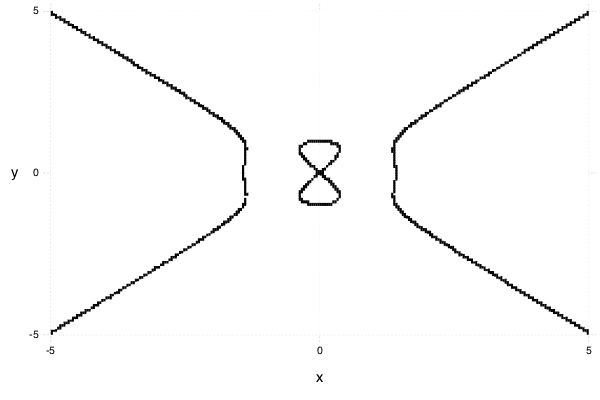

In [ ]:
using Plots, ImplicitEquations
gadfly()

a,b = -1,2
f(x,y) = y^4 - x^4 + a*y^2 + b*x^2
r = (f==0)
plot(r)

<p>The <code>f &#61;&#61; 0</code> expression above creates a <code>Predicate</code> that is graphed by <code>plot</code>. For all but the case of <code>f&#61;&#61;g</code> (for two functions) <code>Predicate</code>s are generated by overloading the logical operators for functions on the left and real values or functions on the right: <code>&lt;</code>, <code>&lt;&#61;</code> (<code>\le&lt;tab&gt;</code>), <code>\Equal&lt;tab&gt;</code>, <code>\lessgtr&lt;tab&gt;</code>, <code>&gt;&#61;</code> (<code>\ge&lt;tab&gt;</code>), and <code>&gt;</code> . As <code>&#61;&#61;</code> and <code>&#33;&#61;</code> can already be used to compare functions in a different way, we use either <code>eq&#40;f,g&#41;</code> or <code>neq&#40;f,g&#41;</code> for these comparisons. Should infix notation be preferred, the Unicode operator <code>f \Equal&lt;tab&gt; g</code> or <code>f \lessgtr&lt;tab&gt; g</code> may be used.</p>

<p>For example, the <a href="http://www-history.mcs.st-and.ac.uk/Curves/Trident.html">Trident of Newton</a> can be represented in Cartesian form as follows:</p>

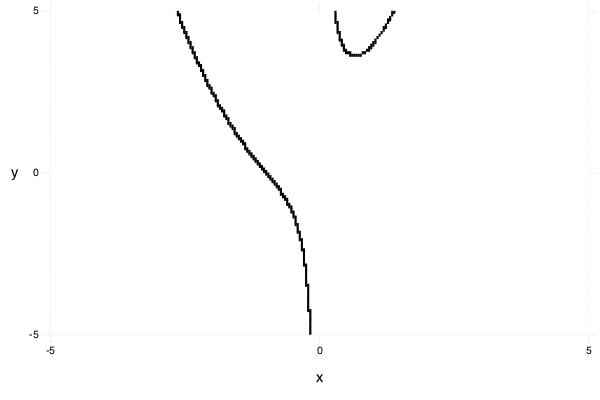

In [ ]:
## trident of Newton
c,d,e,h = 1,1,1,1
f(x,y) = x*y
g(x,y) =c*x^3 + d*x^2 + e*x + h
plot(eq(f,g)) ## aka f ⩵ g (using Unicode\Equal<tab>)

<p>Inequalities can be graphed as well</p>

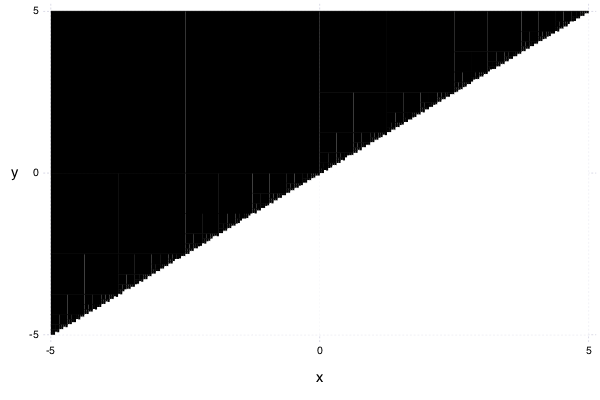

In [ ]:
f(x,y) = x -y
plot(f < 0)

<p>The coloring scheme employed (mostly) follows Tupper and is based on pixels:</p>

<ul>
<li>if a pixel is white, there are no solutions of the predicate <code>r</code> within the pixel;</li>
</ul>

<ul>
<li>if a pixel is black, there is at least one solution of the predicate <code>r</code> within the pixel;</li>
</ul>

<ul>
<li>if a pixel is red, there may or may not be solutions of the predicate <code>r</code> within the pixel. The <code>plot</code> method has the argument <code>show_red&#61;true</code> to show these, otherwise they render as white.</li>
</ul>

<p>(In the above "pixel" does not refer to screen pixels, but rather the  rectangular portions specified through <code>W</code> and <code>H</code>.)</p>

<p>This graph illustrates the algorithm employed here in the graph of the $\sqrt{x}$</p>

<p><img src="http://i.imgur.com/8Mtmb7v.png" alt="Algorithm" /></p>

<p>The basic algorithm is to initially break up the graphing region into square regions. (This uses the number of pixels, which are specified by <code>W</code> and <code>H</code> above.)  There regions are checked for the predicate. If definitely not, the region is painted white; if definitely yes, the region is painted black; else the square region is subdivided into 4 smaller regions and the above is repeated until subdivision would be below the pixel level. At which point, the remaining 1-by-1 pixels are checked for possible solutions, for example for equalities where continuity is known a random sample of points is investigated with the intermediate value theorem.</p>

<p>This example, the <a href="http://yangkidudel.wordpress.com/2011/08/02/love-and-mathematics/">Batman equation</a>, Uses a few new things: the <code>screen</code> function is used to restrict ranges and logical operators to combine predicates.</p>

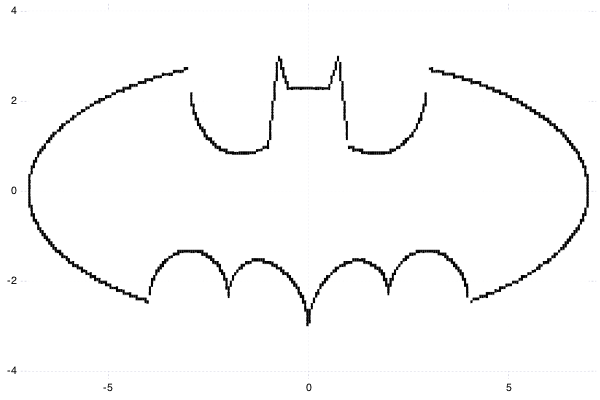

In [ ]:
f0(x,y) = ((x/7)^2 + (y/3)^2 - 1)  *   screen(abs(x)>3) * screen(y > -3*sqrt(33)/7) 
f1(x,y) = ( abs(x/2)-(3 * sqrt(33)-7) * x^2/112 -3 +sqrt(1-(abs((abs(x)-2))-1)^2)-y)
f2(x,y) = y - (9 - 8*abs(x))       *   screen((abs(x)>= 3/4) &  (abs(x) <= 1) )
f3(x,y) = y - (3*abs(x) + 3/4)     *   I_((1/2 < abs(x)) & (abs(x) < 3/4))    # alternate name for screen
f4(x,y) = y - 2.25                 *   I_(abs(x) <= 1/2) 
f5(x,y) = (6 * sqrt(10)/7 + (1.5-.5 * abs(x)) - 6 * sqrt(10)/14 * sqrt(4-(abs(x)-1)^2) -y) * screen(abs(x) >= 1)

r = (f0==0) | (f1==0) | (f2== 0) | (f3==0) | (f4==0) | (f5==0)
plot(r, (-7, 7), (-4, 4))

<p>The above example illustrates a few things:</p>

<ul>
<li>predicates can be joined logically with <code>&amp;</code>, <code>|</code>. Use <code>&#33;</code> for negation.</li>
</ul>

<ul>
<li>The <code>screen</code> function can be used to restrict values according to   some predicate call.</li>
</ul>

<ul>
<li>the logical comparisons such as <code>&#40;abs&#40;x&#41;&gt;&#61; 3/4&#41; &amp; &#40;abs&#40;x&#41; &lt;&#61; 1&#41;</code>   within <code>screen</code> are not typical in that one can't write <code>3/4 &lt;&#61;   abs&#40;x&#41; &lt;&#61; 1</code>, a convenient <code>Julian</code> syntax. This is due to the fact that the "<code>x</code>s"   being evaluated are not numbers, rather intervals via   <code>ValidatedNumerics</code>. For intervals, values may be true, false or   "maybe" so a different interpretation of the logical operators is   given that doesn't lend itself to the more convenient notation.</li>
</ul>

<ul>
<li>rendering can be slow. There are two reasons: images that require a   lot of checking, such as the inequality above, are slow just because   more regions must be analyzed. As well, some operations are slow,   such as division, as adjustments for discontinuities are slow. (And   by slow, it can means really slow. The difference between rendering   <code>&#40;1-x^2&#41;*&#40;2-y^2&#41;</code> and <code>csc&#40;1-x^2&#41;*cot&#40;2-y^2&#41;</code> can be 10 times.)</li>
</ul>

<h2>A "typical" application</h2>

<p>A common calculus problem is to find the tangent line using implicit differentiation. We can plot the predicate to create the implicit graph, then add a layer with <code>plot&#33;</code>:</p>

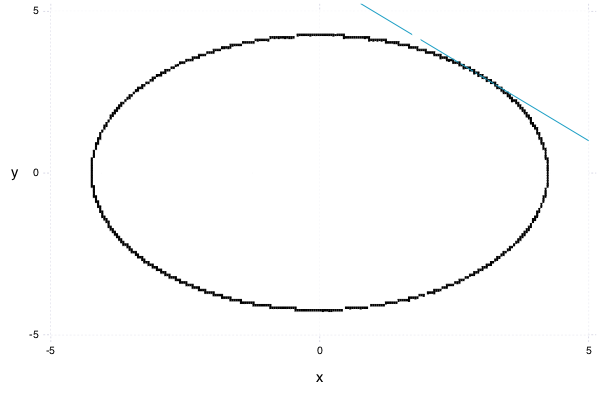

In [ ]:
f(x,y) = x^2 + y^2
plot(f == 2*3^2)

## now add tangent at (3,3)
a,b = 3,3
dydx(a,b) = -b/a             # implicit differentiate to get dy/dx =-y/x
tl(x) = b + dydx(a,b)*(x-a)  
plot!(tl, -5, 5)

<h2>Display</h2>

<p>This package uses the <code>Plots</code> package to create graphics for different backends. </p>

<h2>Alternatives</h2>

<p>Many such plots are simply a single level of a contour plot. Contour plots can be drawn with the <code>Plots</code> package too. A simple contour plot will be faster than this package.</p>

<p>The <code>SymPy</code> package exposes SymPy's <code>plot_implicit</code> feature that will implicitly plot a symbolic expression in 2 variables including inequalities. The algorithm there also follows Tupper and uses interval arithmetic, as possible.</p>

<h2>TODO</h2>

<p><em>LOTS</em>:</p>

<ul>
<li>Check out these graphs to see which can be done - http://www.xamuel.com/graphs-of-implicit-equations/ - http://www.peda.com/grafeq/gallery.html</li>
</ul>

<ul>
<li>branch cut tracking and interval sets are employed by Tupper, these   could be added. This would allow some other functions such as <code>mod</code>,   or <code>±</code> to be defined.</li>
</ul>

<ul>
<li>Tupper sketches out how to be more rigorous with computing whether a region is black or white.</li>
</ul>

<ul>
<li>increase speed (could color 1-pixel regions better if so, perhaps; division checks; type stability).</li>
</ul>